## Лабораторная работа №1 по СОБД
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark
## Часть 2
## Датасет "NYC Yellow Taxi Trip Data"
### Объём: 6.88 Гб 

## Подключение необходимых библиотек

In [1]:
from pyspark.sql import SparkSession
from functools import reduce
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.sql.functions import mean, stddev
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, count, when
from pyspark.sql.functions import lit, floor, min as spark_min, max as spark_max
import builtins
import math

## Инициализация PySpark и создание сессии

In [2]:
conf = SparkConf()
conf.setAppName("Trip Data Analysis")
conf.setMaster("local[*]")  # Локальный режим (все ядра контейнера)
conf.set("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9820")  # Указываем HDFS
conf.set("spark.driver.memory", "4g")
conf.set("spark.driver.cores", "2")
conf.set("spark.executor.memory", "12g")
conf.set("spark.executor.cores", "8")
conf.set("spark.sql.adaptive.enabled", "true")  # Оптимизация запросов

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

## Загрузка данных

Прочтём преобразованный датасет из Части 1 в формате .parquest 

In [3]:
path = "hdfs:///user/vladislav_vaganov/datasets/parquets/tripdata_transformed.parquet"
df = spark.read.parquet(path)

Выведем датафрейм на экран

In [4]:
df.limit(20).toPandas().style\
    .set_properties(**{'text-align': 'left', 'max-width': '0', 'white-space': 'nowrap', 'overflow': 'hidden', 'text-overflow': 'ellipsis'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .format(precision=2)

,VendorID,passenger_count,trip_distance,haversine_distance,RateCodeID,payment_type,is_airport_trip,pickup_hour,pickup_dow,total_amount
0,1,3,10.40,7.18,1,1,1,4,6,36.30
1,1,4,2.20,1.34,1,1,0,4,6,13.55
2,1,1,3.00,2.16,1,1,0,4,6,14.80
3,1,1,5.60,2.81,1,1,0,4,6,24.75
4,1,1,2.40,1.78,1,2,0,4,6,10.30
5,1,1,0.90,0.45,1,1,0,4,6,9.10
6,1,1,6.40,4.22,1,2,0,4,6,22.80
7,1,1,9.10,7.12,1,1,0,4,6,29.30
8,1,1,1.10,0.81,1,2,0,4,6,7.30
9,1,1,1.50,1.52,1,1,0,4,6,11.44


Выведем схему данных

In [6]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- haversine_distance: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- is_airport_trip: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_dow: integer (nullable = true)
 |-- total_amount: double (nullable = true)



Вычислим количество строк в датафрейме

In [52]:
df.count()

47248849

## Анализ столбцов

Введём функцию для рассчёта количества null значений в столбце датафрейма

In [8]:
def count_nulls(data: DataFrame, column_name: str) -> None:
    """
    Подсчёт количества NULL и NOT NULL значений в указанном столбце.
    
    Args:
        data (DataFrame): Входной Spark DataFrame.
        column_name (str): Имя столбца для анализа.
    
    Returns:
        None
    """
    # Проверка, что столбец существует
    if column_name not in data.columns:
        raise ValueError(f"Столбец '{column_name}' отсутствует в DataFrame. Доступные: {data.columns}")
    
    result = data.select(
        count("*").alias("total"),
        count(when(col(column_name).isNull(), 1)).alias("nulls")
    ).collect()[0]
    
    total = result["total"]
    nulls = result["nulls"]
    not_nulls = total - nulls
    
    # Расчёт процента
    null_pct = (nulls / total * 100) if total > 0 else 0.0
    
    print(f"Столбец: {column_name}")
    print(f"  NULL:       {nulls:>10,} ({null_pct:6.2f}%)")
    print(f"  NOT NULL:   {not_nulls:>10,} ({100 - null_pct:6.2f}%)")
    print(f"  Всего:      {total:>10,}")

Создадим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму "ящик с усами" для оценки наличия выбросов

In [9]:
builtin_min = builtins.min
builtin_max = builtins.max

def plot_boxplots(data, columns, sample_fraction=0.01):
    """
    Построение boxplot для числовых столбцов в PySpark DataFrame.
    
    Args:
        data (DataFrame): Входной Spark DataFrame.
        columns (list of str): Список числовых столбцов.
        sample_fraction (float): Доля выбросов для семплирования (0.01 = 1%).
    
    Returns:
        None
    """
    if not columns:
        print("Список столбцов пуст.")
        return

    box_data = []
    stats_per_col = {}  # Для хранения статистики по каждому столбцу

    for column in columns:
        print(f"\nАнализ столбца: {column}")
        
        # === 1. Получаем мин, макс, квантили (одним проходом через approxQuantile + агрегаты) ===
        # approxQuantile — распределённый, быстрый, безопасен для больших данных
        quantiles = data.approxQuantile(column, [0.0, 0.25, 0.5, 0.75, 1.0], 0.01)
        min_val, q1, median, q3, max_val = quantiles
        
        # Среднее и std — отдельный проход (но тоже агрегация → безопасно)
        stats_row = data.agg(
        mean(column).alias("mean_val"),
        stddev(column).alias("std_val")
        ).collect()[0]
        
        mean_val = stats_row["mean_val"]
        std_val = stats_row["std_val"] if stats_row["std_val"] is not None else 0.0

        # === 2. Границы усов по IQR ===
        iqr = q3 - q1
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr

        # Ограничиваем усы реальными мин/макс
        lower_whisker = builtin_max(lower_whisker, min_val)
        upper_whisker = builtin_min(upper_whisker, max_val)

        # === 3. Собираем выбросы (только если они есть и доля > 0) ===
        outliers = []
        if sample_fraction > 0:
            outliers_df = data.filter(
                (col(column) < lower_whisker) | (col(column) > upper_whisker)
            )
            # Семплируем и ограничиваем кол-во точек для графика
            sampled_outliers = (
                outliers_df
                .sample(fraction=sample_fraction)
                .select(column)
                .limit(50)  # Не более 50 точек на график
                .collect()
            )
            outliers = [row[column] for row in sampled_outliers]

            # Добавляем мин/макс, если они — выбросы, но не попали в семпл
            if min_val < lower_whisker and min_val not in outliers:
                outliers.append(min_val)
            if max_val > upper_whisker and max_val not in outliers:
                outliers.append(max_val)

        # === 4. Сохраняем данные для графика и статистику ===
        box_data.append({
            'whislo': lower_whisker,
            'q1': q1,
            'med': median,
            'q3': q3,
            'whishi': upper_whisker,
            'fliers': outliers
        })
        
        stats_per_col[column] = {
            "min": min_val,
            "q1": q1,
            "median": median,
            "q3": q3,
            "max": max_val,
            "mean": mean_val,
            "std": std_val,
            "outliers_count_est": len(outliers) / sample_fraction if sample_fraction > 0 else 0
        }

    # === Вывод статистики по каждому столбцу ===
    for col_name, stats in stats_per_col.items():
        print(f"\nСтолбец: {col_name}")
        print(f"  Минимум:     {stats['min']:>10.2f}")
        print(f"  Q1:          {stats['q1']:>10.2f}")
        print(f"  Медиана:     {stats['median']:>10.2f}")
        print(f"  Q3:          {stats['q3']:>10.2f}")
        print(f"  Максимум:    {stats['max']:>10.2f}")
        print(f"  Среднее:     {stats['mean']:>10.2f}")
        print(f"  Std:         {stats['std']:>10.2f}")
        if sample_fraction > 0:
            print(f"  Выбросов (оценка): ~{int(stats['outliers_count_est']):,}")

    # === Построение графика ===
    fig, ax = plt.subplots(figsize=(12, 2 + 0.6 * len(columns)))
    ax.bxp(
        box_data,
        vert=False,
        positions=range(1, len(columns) + 1),
        widths=0.6,
        showfliers=True,
        patch_artist=True
    )
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Значение')
    ax.set_title('Boxplots числовых признаков')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Создадим функцию для визуализации распределения категориальных признаков

In [10]:
def plot_quant_distribution_full_analysis(data, column, num_bins=100, sample_fraction=0.01):
    """
    Построение гистограммы с полным анализом всех данных.
    """
    if column not in data.columns:
        raise ValueError(f"Столбец '{column}' не найден. Доступные: {data.columns}")
    
    # === 1. Полная статистика по ВСЕМ данным ===
    stats = data.select(
        F.min(col(column)).alias('min_val'),
        F.max(col(column)).alias('max_val'),
        F.mean(col(column)).alias('mean_val'),
        F.stddev(col(column)).alias('std_val'),
        F.expr(f'percentile_approx({column}, 0.5)').alias('median_val')
    ).collect()[0]
    
    min_val, max_val, mean_val, std_val, median_val = stats
    
    if min_val is None:
        print(f"Столбец '{column}' содержит только NULL-значения.")
        return
        
    if min_val == max_val:
        print(f"Все значения в '{column}' одинаковы: {min_val}")
        plt.figure(figsize=(10, 4))
        plt.axvline(min_val, color='red', linestyle='--')
        plt.title(f"Все значения = {min_val}")
        plt.show()
        return

    # === 2. Семплируем ТОЛЬКО для визуализации ===
    sampled_data = data.sample(fraction=sample_fraction).select(column)
    
    try:
        pdf = sampled_data.toPandas()
    except Exception as e:
        print(f"Ошибка при преобразовании в Pandas: {e}")
        return

    if pdf.empty:
        print("Семпл оказался пустым. Увеличьте sample_fraction.")
        return

    values = pdf[column].dropna()

    if values.empty:
        print(f"Все значения в '{column}' — NULL.")
        return

    # === 3. Строим гистограмму (только визуализация по семплу) ===
    plt.figure(figsize=(12, 5))
    sns.histplot(values, bins=num_bins, kde=True, color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f'Распределение "{column}"')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # === 4. Выводим статистику по ВСЕМ данным ===
    print(f"\nСтатистика по '{column}':")
    print(f"  Минимум:  {min_val:,.4f}")
    print(f"  Максимум: {max_val:,.4f}")
    print(f"  Среднее:  {mean_val:,.4f}")
    print(f"  Медиана:  {median_val:,.4f}")
    print(f"  Std:      {std_val:,.4f}")
    print(f"  Размер семпла для визуализации: {len(values):,} значений")
    print(f"  Общий размер данных: {data.count():,} строк")

Создадим функцию для расчета корреляции между количественными признаками

In [38]:
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np

def compute_and_visualize_correlation_matrix_full(data, columns):
    """
    Вычисляет и визуализирует корреляционную матрицу по ВСЕМ данным.
    
    Args:
        data (DataFrame): PySpark DataFrame.
        columns (list[str]): Список ЧИСЛОВЫХ колонок.
    
    Returns:
        None
    """
    # Проверка наличия колонок
    missing = [c for c in columns if c not in data.columns]
    if missing:
        raise ValueError(f"Отсутствующие колонки: {missing}. Доступные: {data.columns}")
    
    print("Вычисление корреляции по ВСЕМ данным...")
    
    # === 1. Вычисляем корреляцию по ВСЕМ данным ===
    # Создаем векторный столбец
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    vector_data = assembler.transform(data).select("features")
    
    # Вычисляем матрицу корреляции Пирсона
    corr_matrix = Correlation.corr(vector_data, "features").collect()[0][0]
    
    # Преобразуем в numpy array
    corr_array = corr_matrix.toArray()
    
    # === 2. Семплируем только для дополнительной проверки ===
    sample_fraction = 0.01  # Только для визуализации распределений
    sampled_pdf = (
        data.select(*columns)
        .sample(fraction=sample_fraction)
        .toPandas()
    )
    
    # === 3. Визуализация ===
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_array, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        linewidths=0.5,
        square=True,
        cbar_kws={"shrink": 0.8},
        xticklabels=columns,
        yticklabels=columns
    )
    plt.title('Корреляционная матрица (ВСЕ данные)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # === 4. Вывод сильных корреляций ===
    print("\nСильные корреляции (|r| ≥ 0.5) по ВСЕМ данным:")
    strong_correlations = []
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            val = corr_array[i, j]
            if builtins.abs(val) >= 0.5:
                col1, col2 = columns[i], columns[j]
                strong_correlations.append((col1, col2, val))
                print(f"  {col1} ↔ {col2}: {val:.3f}")
    
    if not strong_correlations:
        print("  Сильных корреляций не обнаружено")
    
    # === 5. Дополнительная проверка по семплу ===
    print(f"\nПроверка по семплу ({sample_fraction*100:.1f}% данных):")
    sample_corr = sampled_pdf.corr(method='pearson').values
    discrepancies = []
    
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            full_val = corr_array[i, j]
            sample_val = sample_corr[i, j]
            diff = abs(full_val - sample_val)
            if diff > 0.1:  # Разница более 10%
                discrepancies.append((columns[i], columns[j], full_val, sample_val, diff))
    
    if discrepancies:
        print("Заметные расхождения между полными данными и семплом:")
        for col1, col2, full, sample, diff in discrepancies:
            print(f"  {col1} ↔ {col2}: полные={full:.3f}, семпл={sample:.3f} (разница={diff:.3f})")
    else:
        print("Семпл хорошо отражает общие корреляции")
    
    return corr_array

## Анализ столбца "trip_distance"

Проверим "trip_distance" на число null значений

In [12]:
count_nulls(df, "trip_distance")

Столбец: trip_distance
  NULL:                4 (  0.00%)
  NOT NULL:   47,248,845 (100.00%)
  Всего:      47,248,849


Исключим из датафрейма строки, в которых в столбце "trip_distance" есть null значения

In [13]:
df = df.dropna(subset=["trip_distance"])
count_nulls(df, "trip_distance")

Столбец: trip_distance
  NULL:                0 (  0.00%)
  NOT NULL:   47,248,845 (100.00%)
  Всего:      47,248,845


Рассчитаем статистические показатели и построим график "ящик с усами"


Анализ столбца: trip_distance

Столбец: trip_distance
  Минимум:     -3390583.80
  Q1:                1.00
  Медиана:           1.67
  Q3:                3.07
  Максимум:    19072628.80
  Среднее:           7.51
  Std:            6487.66
  Выбросов (оценка): ~52,000


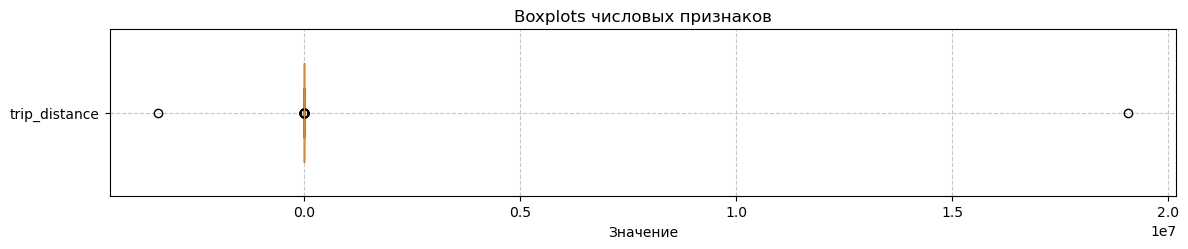

In [14]:
plot_boxplots(df, columns=["trip_distance"], sample_fraction=0.001)

В столбце "trip_distance" значительные выбросы. Минимальная дистанция поездки равна "-3390583.80", а максимальная - "19072628", что невозможно. Очистим датафрейм от значений x, где x =< 0 и x >= 50.


Анализ столбца: trip_distance

Столбец: trip_distance
  Минимум:           0.01
  Q1:                1.00
  Медиана:           1.68
  Q3:                3.02
  Максимум:         19.99
  Среднее:           2.79
  Std:               3.22
  Выбросов (оценка): ~51,000


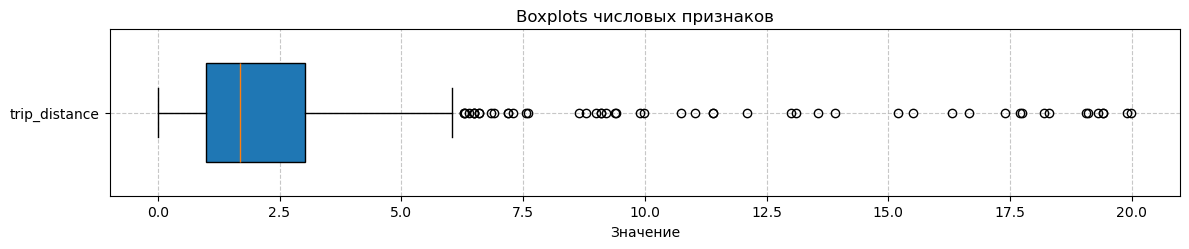

In [15]:
df_cleaned = df.filter(
    (col("trip_distance") > 0) & 
    (col("trip_distance") < 20)
)
plot_boxplots(df_cleaned, columns=["trip_distance"], sample_fraction=0.001)

Визуализируем распределение категориального признака

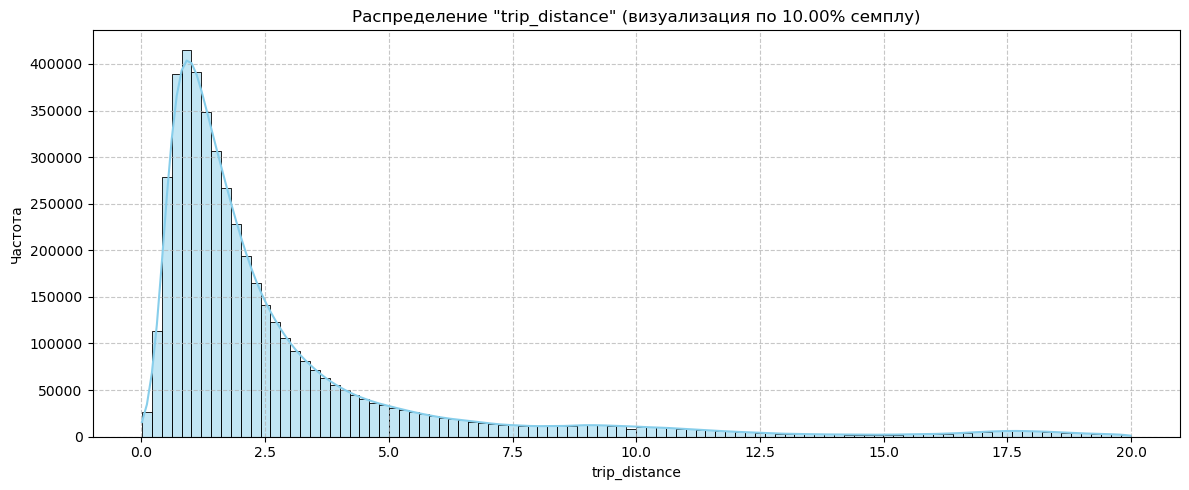


Статистика по 'trip_distance' (ПО ВСЕМ ДАННЫМ):
  Минимум:  0.0100
  Максимум: 19.9900
  Среднее:  2.7868
  Медиана:  1.6900
  Std:      3.2214
  Размер семпла для визуализации: 4,675,604 значений
  Общий размер данных: 46,735,095 строк


In [17]:
plot_quant_distribution_full_analysis(df_cleaned, "trip_distance", num_bins=100, sample_fraction=0.1)

Выбросы обработаны. Выведем число строк в датафрейме.

In [18]:
df_cleaned.count()

46735095

## Анализ столбца "haversine_distance"

Проверим "haversine_distance" на число null значений

In [19]:
count_nulls(df_cleaned, "haversine_distance")

Столбец: haversine_distance
  NULL:                0 (  0.00%)
  NOT NULL:   46,735,095 (100.00%)
  Всего:      46,735,095


Null значения отсутствуют. Проанализируем статистические показатели и построим "ящик с усами"


Анализ столбца: haversine_distance

Столбец: haversine_distance
  Минимум:           0.00
  Q1:                0.74
  Медиана:           1.25
  Q3:                2.29
  Максимум:      10768.03
  Среднее:          14.74
  Std:             261.51
  Выбросов (оценка): ~51,000


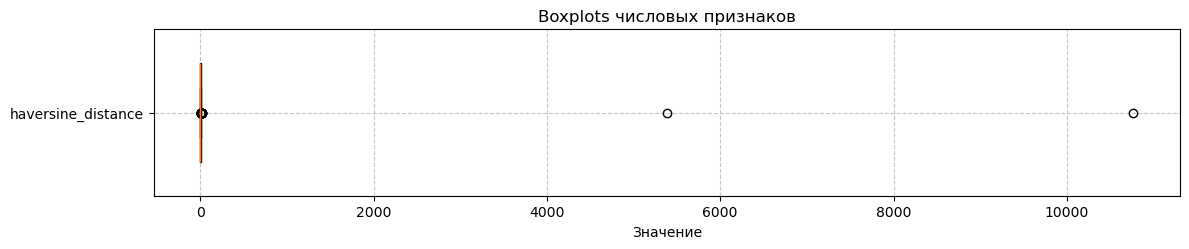

In [20]:
plot_boxplots(df_cleaned, columns=["haversine_distance"], sample_fraction=0.001)

Очистим датафрейм от значений x, где x =< 0 и x > 16.


Анализ столбца: haversine_distance

Столбец: haversine_distance
  Минимум:           0.00
  Q1:                0.75
  Медиана:           1.27
  Q3:                2.31
  Максимум:         16.00
  Среднее:           2.03
  Std:               2.22
  Выбросов (оценка): ~51,000


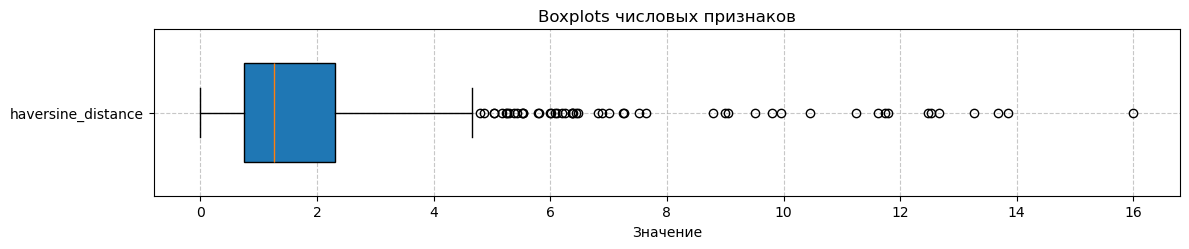

In [21]:
df_cleaned = df_cleaned.filter(
    (col("haversine_distance") > 0) & 
    (col("haversine_distance") <= 16)
)
plot_boxplots(df_cleaned, columns=["haversine_distance"], sample_fraction=0.001)

Визуализируем распределение категориального признака. Анализ проведём на 10% семплированных данных

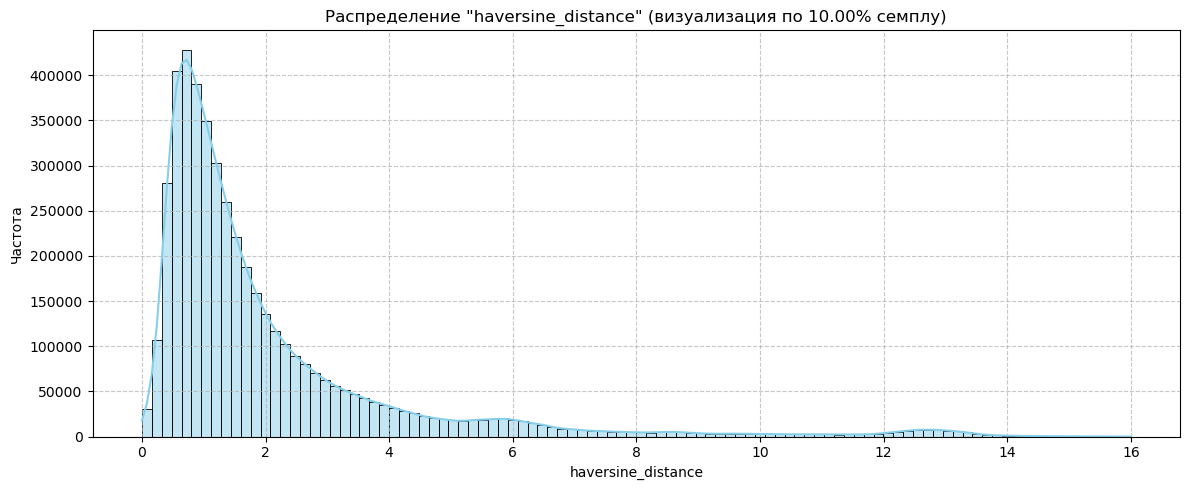


Статистика по 'haversine_distance' (ПО ВСЕМ ДАННЫМ):
  Минимум:  0.0003
  Максимум: 15.9989
  Среднее:  2.0317
  Медиана:  1.2796
  Std:      2.2184
  Размер семпла для визуализации: 4,582,776 значений
  Общий размер данных: 45,833,727 строк


In [22]:
plot_quant_distribution_full_analysis(df_cleaned, "haversine_distance", num_bins=100, sample_fraction=0.1)

Выбросы обработаны. Выведем число строк в датафрейме.

In [23]:
df_cleaned.count()

45833727

## Анализ столбца "total_amount"

Проверим "total_amount" на число null значений

In [24]:
count_nulls(df_cleaned, "total_amount")

Столбец: total_amount
  NULL:                0 (  0.00%)
  NOT NULL:   45,833,727 (100.00%)
  Всего:      45,833,727


Null значения отсутствуют. Проанализируем статистические показатели и построим "ящик с усами"


Анализ столбца: total_amount

Столбец: total_amount
  Минимум:        -300.80
  Q1:                8.30
  Медиана:          11.60
  Q3:               16.80
  Максимум:    3950611.60
  Среднее:          15.22
  Std:             583.89
  Выбросов (оценка): ~52,000


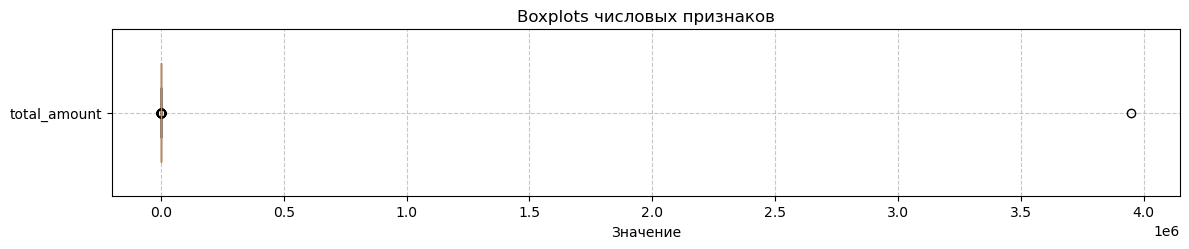

In [25]:
plot_boxplots(df_cleaned, columns=["total_amount"], sample_fraction=0.001)

В столбце "total_amount" значительные выбросы. Минимальная стоимость поездки равна "-300.80", а максимальная - "3950611.60", что невозможно. Очистим датафрейм от значений x, где x =< 0 и x > 75.


Анализ столбца: total_amount

Столбец: total_amount
  Минимум:           0.01
  Q1:                8.30
  Медиана:          11.60
  Q3:               16.80
  Максимум:         75.00
  Среднее:          14.95
  Std:              11.10
  Выбросов (оценка): ~51,000


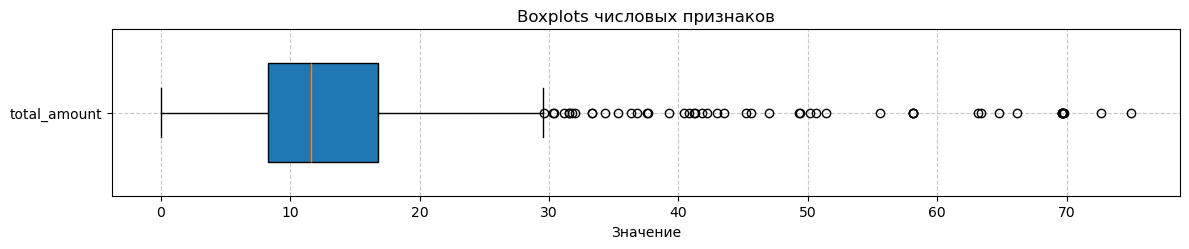

In [26]:
df_cleaned = df_cleaned.filter(
    (col("total_amount") > 0) & 
    (col("total_amount") <= 75)
)
plot_boxplots(df_cleaned, columns=["total_amount"], sample_fraction=0.001)

Визуализируем распределение категориального признака. Анализ проведём на 10% семплированных данных

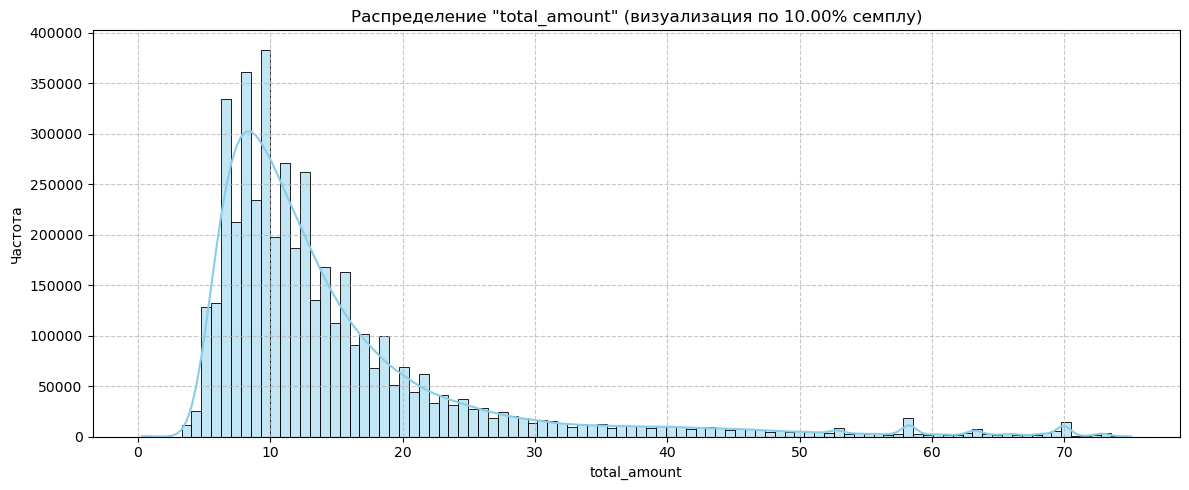


Статистика по 'total_amount' (ПО ВСЕМ ДАННЫМ):
  Минимум:  0.0100
  Максимум: 75.0000
  Среднее:  14.9543
  Медиана:  11.4200
  Std:      11.1012
  Размер семпла для визуализации: 4,570,513 значений
  Общий размер данных: 45,706,755 строк


In [27]:
plot_quant_distribution_full_analysis(df_cleaned, "total_amount", num_bins=100, sample_fraction=0.1)

Выбросы обработаны. Выведем число строк в датафрейме.

In [28]:
df_cleaned.count()

45706755

## Анализ столбца "passenger_count"

Проверим "passenger_count" на число null значений

In [29]:
count_nulls(df_cleaned, "passenger_count")

Столбец: passenger_count
  NULL:                0 (  0.00%)
  NOT NULL:   45,706,755 (100.00%)
  Всего:      45,706,755


Null значения отсутствуют. Проанализируем статистические показатели и построим "ящик с усами"


Анализ столбца: passenger_count

Столбец: passenger_count
  Минимум:           0.00
  Q1:                1.00
  Медиана:           1.00
  Q3:                2.00
  Максимум:          9.00
  Среднее:           1.67
  Std:               1.33
  Выбросов (оценка): ~51,000


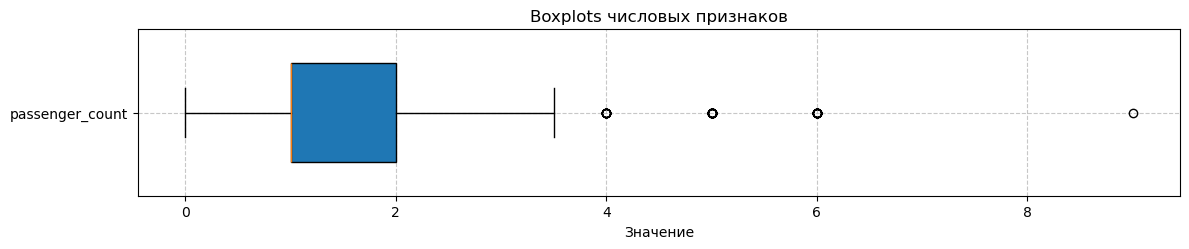

In [30]:
plot_boxplots(df_cleaned, columns=["passenger_count"], sample_fraction=0.001)

Исключим из датафрейма строки, в которые passenger_count == 0


Анализ столбца: passenger_count

Столбец: passenger_count
  Минимум:           1.00
  Q1:                1.00
  Медиана:           1.00
  Q3:                2.00
  Максимум:          9.00
  Среднее:           1.67
  Std:               1.33
  Выбросов (оценка): ~51,000


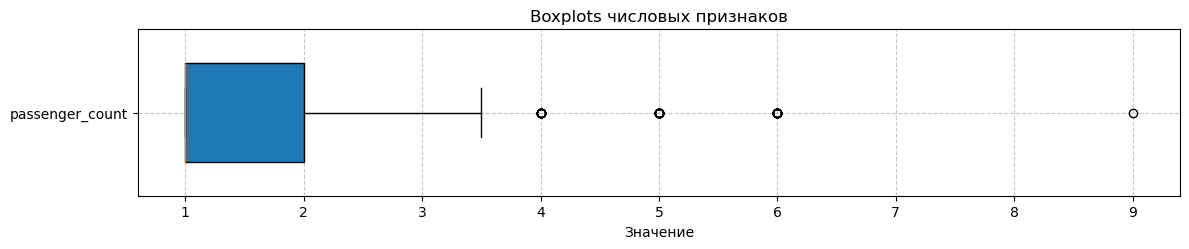

In [31]:
df_cleaned = df_cleaned.filter(
    (col("passenger_count") >= 1) 
)
plot_boxplots(df_cleaned, columns=["passenger_count"], sample_fraction=0.001)

Выбросы обработаны. Выведем число строк в датафрейме.

In [32]:
df_cleaned.count()

45700491

## Анализ столбца "payment_type"

In [33]:
count_nulls(df_cleaned, "payment_type")

Столбец: payment_type
  NULL:                0 (  0.00%)
  NOT NULL:   45,700,491 (100.00%)
  Всего:      45,700,491



Анализ столбца: payment_type

Столбец: payment_type
  Минимум:           1.00
  Q1:                1.00
  Медиана:           1.00
  Q3:                2.00
  Максимум:          5.00
  Среднее:           1.35
  Std:               0.49
  Выбросов (оценка): ~43,000


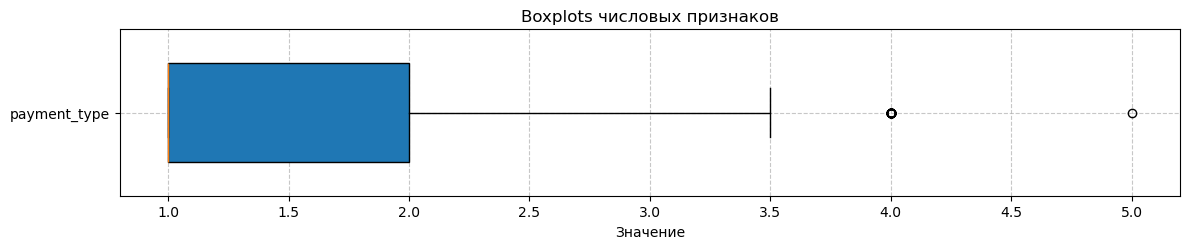

In [34]:
plot_boxplots(df_cleaned, columns=["payment_type"], sample_fraction=0.001)

В виду того, что в датафрейме значение столбца payment_type == 1, означает безналичную оплату, а значение столбца payment_type == 2 - оплату наличными, то исключим из датафрейма строки, в которых у столбца payment_type иные численные значения


Анализ столбца: payment_type

Столбец: payment_type
  Минимум:           1.00
  Q1:                1.00
  Медиана:           1.00
  Q3:                2.00
  Максимум:          2.00
  Среднее:           1.34
  Std:               0.47
  Выбросов (оценка): ~0


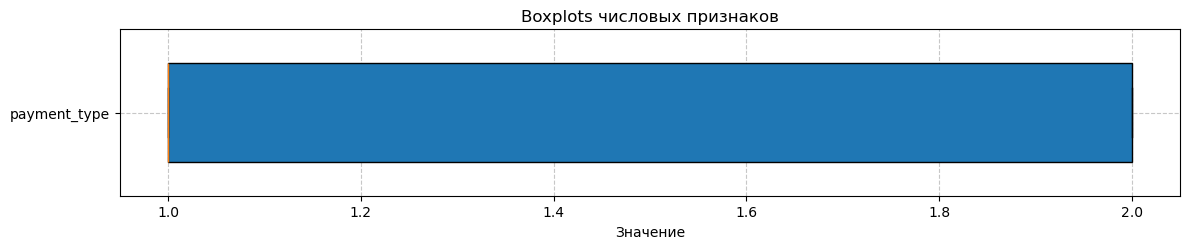

In [35]:
df_cleaned = df_cleaned.filter(
    (col("payment_type") == 1) | 
    (col("payment_type") == 2)
)
plot_boxplots(df_cleaned, columns=["payment_type"], sample_fraction=0.001)

Посчитаем количество поездок с оплатой наличными и безналичной оплатой

In [36]:
# Подсчёт количества записей для payment_type = 1 и 2 за один проход
result = df_cleaned.agg(
    count(when(col("payment_type") == 1, 1)).alias("count_type_1"),
    count(when(col("payment_type") == 2, 1)).alias("count_type_2")
).collect()[0]

count_1 = result["count_type_1"]
count_2 = result["count_type_2"]
total = count_1 + count_2

print(f"payment_type == 1 (Безналичная оплата): {count_1:,} ({100 * count_1 / total:.2f}%)")
print(f"payment_type === 2 (Наличная оплата):   {count_2:,} ({100 * count_2 / total:.2f}%)")
print(f"Всего:                                  {total:,}")

payment_type == 1 (Безналичная оплата): 29,929,700 (65.72%)
payment_type === 2 (Наличная оплата):   15,613,584 (34.28%)
Всего:                                  45,543,284


## Расчет корреляции между количественными признаками

Определим количественные признаки

In [37]:
numeric_columns = [
    "VendorID",
    "passenger_count",
    "trip_distance",
    "RateCodeID",
    "payment_type",
    "haversine_distance",
    "pickup_hour",
    "pickup_dow",
    "total_amount"
]

Семплирование 10.00% данных для корреляции...


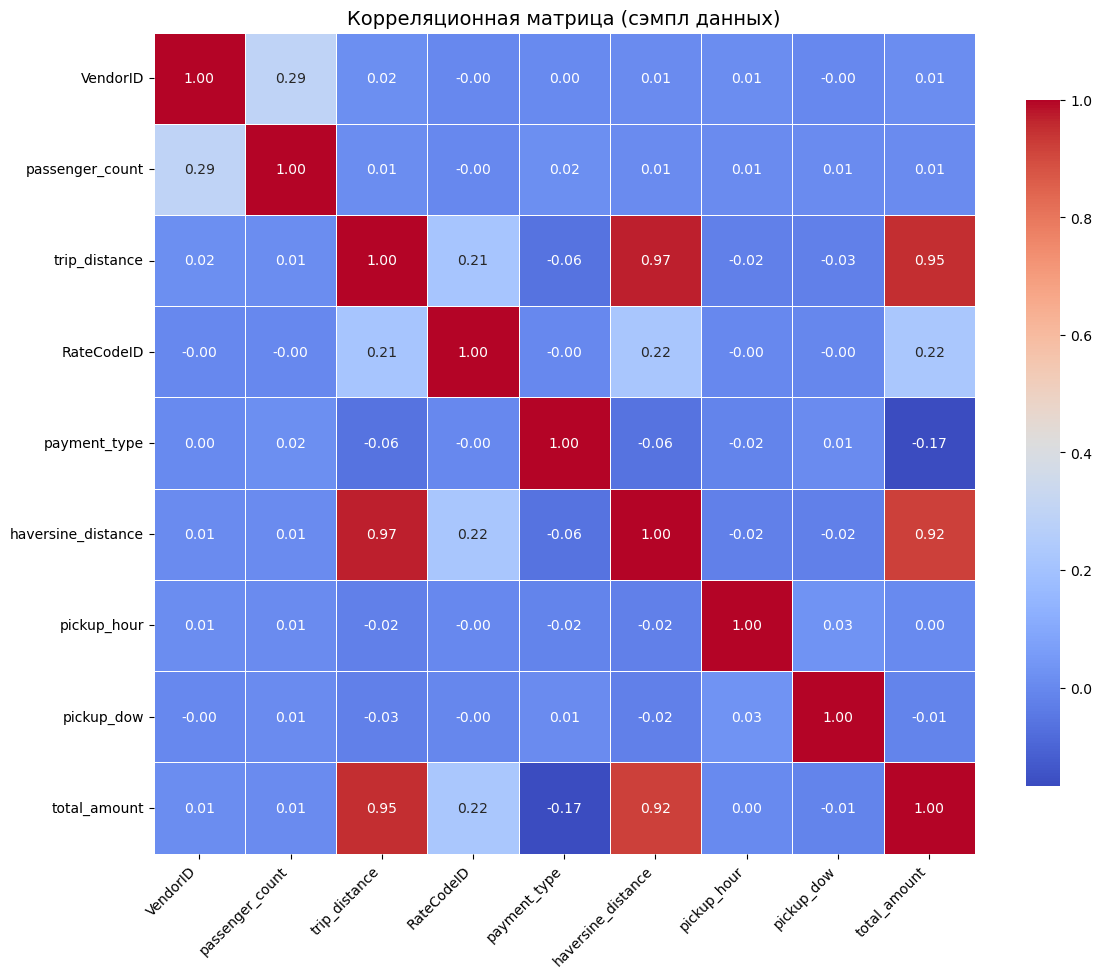


Сильные корреляции (|r| ≥ 0.5):
  trip_distance ↔ haversine_distance: 0.972
  trip_distance ↔ total_amount: 0.954
  haversine_distance ↔ total_amount: 0.922


In [39]:
compute_and_visualize_correlation_matrix(df_cleaned, numeric_columns)

Таким образом, на стоимость поездки наиболее сильно влияют признаки "trip_distance" и "haversine_distance", характеризующие расстояние поездки в милях. В меньше степени на стоимость поздки влияет RateCodeID (код типа тарифа). 

## Сохранение преобразованного датафрейма

In [96]:
path_output = "hdfs:///user/vladislav_vaganov/datasets/parquets/tripdata_cleaned.parquet"

Сохраним датафрейм в виде файла "tripdata_cleaned.parquet"

In [97]:
df_cleaned.write \
    .mode("overwrite") \
    .option("compression", "snappy") \
    .parquet(path_output)

Останавливаем spark-сессию

In [98]:
spark.stop()